# Module 06: LSTM (Long Short-Term Memory)

**Solving Vanishing Gradients with Gating Mechanisms**

---

## 1. Objectives

- ✅ Understand LSTM architecture and all gates
- ✅ Implement LSTM from scratch
- ✅ Know how cell state solves vanishing gradients
- ✅ Use PyTorch nn.LSTM effectively

## 2. Prerequisites

- [Module 05: RNN Fundamentals](../05_rnn_fundamentals/05_rnn_fundamentals.ipynb)

## 3. Intuition & Motivation

### The Problem with Vanilla RNN

- Vanishing gradients for long sequences
- Can't learn long-term dependencies

### LSTM Solution: Cell State as "Conveyor Belt"

```
Cell State (C): ─────────────────────────────────────>
                    ↑ add        ↑ add        ↑ add
                    │            │            │
                  [×forget]    [×forget]    [×forget]
                    │            │            │
Hidden (h): ────────┴────────────┴────────────┴────>
```

Key idea: Information flows through cell state with **additive** updates (not multiplicative like RNN).

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

print("Setup complete!")

Setup complete!


## 4. Mathematical Foundation

### LSTM Gates (at each time step t)

**1. Forget Gate** - What to forget from cell state:
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

**2. Input Gate** - What new info to add:
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$

**3. Candidate Cell State** - New candidate values:
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

**4. Cell State Update** - Forget old + add new:
$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$

**5. Output Gate** - What to output:
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$

**6. Hidden State** - Filtered cell state:
$$h_t = o_t \odot \tanh(C_t)$$

Where $\sigma$ is sigmoid, $\odot$ is element-wise multiplication.

## 5. LSTM from Scratch

In [2]:
class LSTMCell:
    """LSTM cell from scratch (NumPy)."""

    def __init__(self, input_size: int, hidden_size: int):
        self.hidden_size = hidden_size
        combined_size = input_size + hidden_size

        # Xavier initialization
        scale = np.sqrt(2.0 / combined_size)

        # Forget gate
        self.W_f = np.random.randn(hidden_size, combined_size) * scale
        self.b_f = np.ones((hidden_size, 1))  # Start with forget bias = 1

        # Input gate
        self.W_i = np.random.randn(hidden_size, combined_size) * scale
        self.b_i = np.zeros((hidden_size, 1))

        # Candidate
        self.W_c = np.random.randn(hidden_size, combined_size) * scale
        self.b_c = np.zeros((hidden_size, 1))

        # Output gate
        self.W_o = np.random.randn(hidden_size, combined_size) * scale
        self.b_o = np.zeros((hidden_size, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def forward(self, x, h_prev, c_prev):
        """
        Single LSTM step.

        Args:
            x: (input_size, 1)
            h_prev: (hidden_size, 1)
            c_prev: (hidden_size, 1)
        """
        # Concatenate input and previous hidden
        combined = np.vstack([h_prev, x])  # (hidden+input, 1)

        # Forget gate
        f = self.sigmoid(self.W_f @ combined + self.b_f)

        # Input gate
        i = self.sigmoid(self.W_i @ combined + self.b_i)

        # Candidate
        c_tilde = np.tanh(self.W_c @ combined + self.b_c)

        # Cell state update
        c = f * c_prev + i * c_tilde

        # Output gate
        o = self.sigmoid(self.W_o @ combined + self.b_o)

        # Hidden state
        h = o * np.tanh(c)

        return h, c, {'f': f, 'i': i, 'o': o, 'c_tilde': c_tilde}

# Test LSTM cell
cell = LSTMCell(input_size=10, hidden_size=20)
x = np.random.randn(10, 1)
h = np.zeros((20, 1))
c = np.zeros((20, 1))

h_new, c_new, gates = cell.forward(x, h, c)
print(f"Input shape: {x.shape}")
print(f"Hidden shape: {h_new.shape}")
print(f"Cell shape: {c_new.shape}")
print(f"Gate values (sample): f={gates['f'][0,0]:.3f}, i={gates['i'][0,0]:.3f}, o={gates['o'][0,0]:.3f}")

Input shape: (10, 1)
Hidden shape: (20, 1)
Cell shape: (20, 1)
Gate values (sample): f=0.901, i=0.544, o=0.352


In [3]:
class LSTM:
    """Full LSTM layer from scratch."""

    def __init__(self, input_size: int, hidden_size: int):
        self.cell = LSTMCell(input_size, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, inputs, h0=None, c0=None):
        """
        Process sequence.

        Args:
            inputs: List of (input_size, 1) arrays
        """
        if h0 is None:
            h0 = np.zeros((self.hidden_size, 1))
        if c0 is None:
            c0 = np.zeros((self.hidden_size, 1))

        h, c = h0, c0
        outputs = []

        for x in inputs:
            h, c, _ = self.cell.forward(x, h, c)
            outputs.append(h)

        return outputs, (h, c)

# Test full LSTM
lstm = LSTM(input_size=10, hidden_size=20)
seq = [np.random.randn(10, 1) for _ in range(15)]
outputs, (h_n, c_n) = lstm.forward(seq)

print(f"Sequence length: {len(seq)}")
print(f"Number of outputs: {len(outputs)}")
print(f"Final hidden shape: {h_n.shape}")

Sequence length: 15
Number of outputs: 15
Final hidden shape: (20, 1)


## 6. PyTorch Implementation

In [4]:
# PyTorch LSTM
lstm_pt = nn.LSTM(
    input_size=10,
    hidden_size=20,
    num_layers=2,
    batch_first=True,
    dropout=0.1,
    bidirectional=False
)

# Input: (batch, seq, features)
x = torch.randn(32, 15, 10)

# Initial states: (num_layers, batch, hidden)
h0 = torch.zeros(2, 32, 20)
c0 = torch.zeros(2, 32, 20)

# Forward
output, (h_n, c_n) = lstm_pt(x, (h0, c0))

print(f"Input: {x.shape}")
print(f"Output: {output.shape} (all hidden states)")
print(f"h_n: {h_n.shape} (final hidden per layer)")
print(f"c_n: {c_n.shape} (final cell per layer)")

Input: torch.Size([32, 15, 10])
Output: torch.Size([32, 15, 20]) (all hidden states)
h_n: torch.Size([2, 32, 20]) (final hidden per layer)
c_n: torch.Size([2, 32, 20]) (final cell per layer)


## 7. Why LSTM Solves Vanishing Gradients

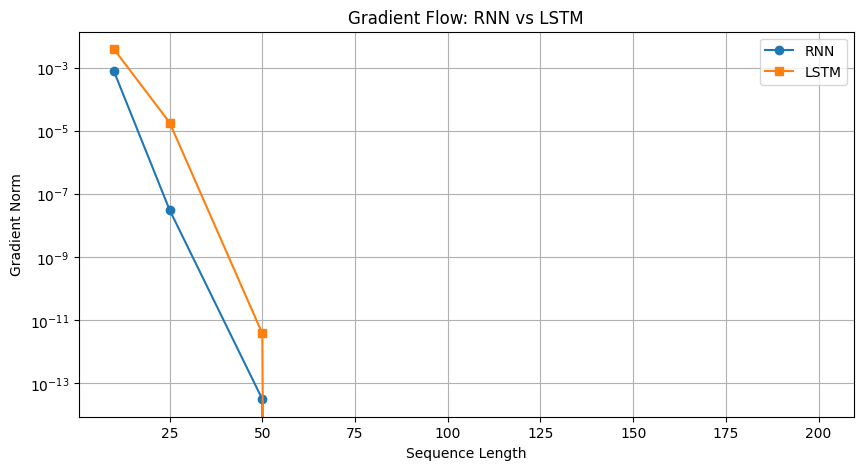

LSTM maintains gradients much better over long sequences!


In [5]:
# Compare gradient flow: RNN vs LSTM
def compare_gradients(seq_lengths):
    rnn_norms, lstm_norms = [], []

    for seq_len in seq_lengths:
        # RNN
        rnn = nn.RNN(10, 20, batch_first=True)
        x_rnn = torch.randn(1, seq_len, 10, requires_grad=True)
        out_rnn, _ = rnn(x_rnn)
        out_rnn[:, -1].sum().backward()
        rnn_norms.append(x_rnn.grad[:, 0].norm().item())

        # LSTM
        lstm = nn.LSTM(10, 20, batch_first=True)
        x_lstm = torch.randn(1, seq_len, 10, requires_grad=True)
        out_lstm, _ = lstm(x_lstm)
        out_lstm[:, -1].sum().backward()
        lstm_norms.append(x_lstm.grad[:, 0].norm().item())

    return rnn_norms, lstm_norms

seq_lengths = [10, 25, 50, 100, 200]
rnn_norms, lstm_norms = compare_gradients(seq_lengths)

plt.figure(figsize=(10, 5))
plt.plot(seq_lengths, rnn_norms, 'o-', label='RNN')
plt.plot(seq_lengths, lstm_norms, 's-', label='LSTM')
plt.xlabel('Sequence Length')
plt.ylabel('Gradient Norm')
plt.title('Gradient Flow: RNN vs LSTM')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

print("LSTM maintains gradients much better over long sequences!")

## 8. LSTM for Classification

In [6]:
class LSTMClassifier(nn.Module):
    """LSTM for text classification."""

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=0.3 if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (batch, seq_len)
        embedded = self.embedding(x)  # (batch, seq, embed)
        _, (h_n, _) = self.lstm(embedded)  # h_n: (layers, batch, hidden)
        out = self.fc(h_n[-1])  # Use last layer's hidden
        return out

# Test
model = LSTMClassifier(vocab_size=5000, embed_dim=100, hidden_dim=128, num_classes=2)
x = torch.randint(0, 5000, (32, 50))  # batch=32, seq=50
out = model(x)
print(f"Input: {x.shape} → Output: {out.shape}")

Input: torch.Size([32, 50]) → Output: torch.Size([32, 2])


## 9. 🔥 Real-World Usage

### When LSTM Still Makes Sense (2024)

| Use Case | Why LSTM |
|----------|----------|
| Streaming data | Process token-by-token |
| Edge devices | Lower memory than transformers |
| Small datasets | Less prone to overfitting |
| Time series | Often matches transformer performance |

### LSTM vs Transformer

| Aspect | LSTM | Transformer |
|--------|------|-------------|
| Parallelization | Sequential | Fully parallel |
| Memory | O(1) per step | O(n²) attention |
| Long-range | Limited (~100-200) | Better with pos encoding |
| Training speed | Slower | Faster |

## 10. Interview Questions

**Q1: Walk through all LSTM gates. What does each do?**
<details><summary>Answer</summary>

- **Forget gate (f)**: Decides what to forget from cell state (0-1 per dimension)
- **Input gate (i)**: Decides what new info to add
- **Candidate (c̃)**: Proposes new values to add
- **Cell update**: C = f⊙C_prev + i⊙c̃
- **Output gate (o)**: Decides what parts of cell to output
- **Hidden**: h = o⊙tanh(C)
</details>

**Q2: How does cell state help with vanishing gradients?**
<details><summary>Answer</summary>

Cell state uses **additive** updates (C = f⊙C_prev + i⊙c̃) instead of multiplicative. Gradients flow directly through the addition, creating a "gradient highway". The forget gate can be close to 1, allowing information to persist.
</details>

**Q3: What's the difference between hidden state and cell state?**
<details><summary>Answer</summary>

- **Cell state (C)**: Long-term memory, flows with minimal transformation
- **Hidden state (h)**: Short-term/working memory, filtered version of cell state (h = o⊙tanh(C))
</details>

## 11. Summary

- **LSTM**: Gated architecture solving vanishing gradients
- **Gates**: Forget (f), Input (i), Output (o)
- **Cell state**: Long-term memory with additive updates
- **Key insight**: C = f⊙C_prev + i⊙c̃ (additive, not multiplicative)
- **Practice**: Still useful for streaming and resource-constrained settings

## 12. Exercises

1. Implement backward pass for LSTM from scratch
2. Visualize gate activations over a sequence
3. Compare LSTM vs RNN on long-range dependency task
4. Implement peephole LSTM variant

## 13. References

- [LSTM Original Paper (1997)](https://www.bioinf.jku.at/publications/older/2604.pdf)
- [Understanding LSTMs (Colah's Blog)](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [PyTorch LSTM Docs](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

---
**Next:** [Module 07: GRU](../07_gru/07_gru.ipynb)